In [1]:
YELP_TOKEN = "KCnsvsZnQ34GkM5cGvGH-ntoqkvo9xEJqib6Jl0b6cRfnItmf5xNT_6s03_QOONYJ5ZnSS3pc5jQV084lVAlkJaROBwVPJQebgkAwGyV2EwlqquykzPBJQJWFS0FXnYx"

In [2]:
import requests
import json

import matplotlib.pyplot as plt
import numpy as np

import random
from pprint import pprint

In [3]:
MyList=[0,0,0,0,0,0,0,0,0,0]
for i in range(1,10):
    MyList[i]=50*i

In [4]:
MyList

[0, 50, 100, 150, 200, 250, 300, 350, 400, 450]

In [5]:
# since each request only return 50 records as limit, I used foor loop to get 500 records by setting different offsets and adding them together
All=[]
for k in MyList:
    r = requests.get("https://api.yelp.com/v3/businesses/search?location=Toronto&limit=50&offset=%s"%k, headers={"Authorization": "Bearer %s" % YELP_TOKEN})
    All=r.json()["businesses"]+All

In [6]:
All[0]

{'id': 'WRPlRsDK47DFl3dz65zhYg',
 'alias': 'pinkys-ca-phe-toronto',
 'name': "Pinky's Ca Phe",
 'image_url': 'https://s3-media4.fl.yelpcdn.com/bphoto/CKW6HMtg2AtdKJdlI4anrw/o.jpg',
 'is_closed': False,
 'url': 'https://www.yelp.com/biz/pinkys-ca-phe-toronto?adjust_creative=Xo8qggBLM36q8rVxw-LcNw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=Xo8qggBLM36q8rVxw-LcNw',
 'review_count': 144,
 'categories': [{'alias': 'vietnamese', 'title': 'Vietnamese'}],
 'rating': 4.0,
 'coordinates': {'latitude': 43.6557045377745, 'longitude': -79.4138196639558},
 'transactions': [],
 'price': '$$',
 'location': {'address1': '53 Clinton Street',
  'address2': '',
  'address3': None,
  'city': 'Toronto',
  'zip_code': 'M6G 2Y4',
  'country': 'CA',
  'state': 'ON',
  'display_address': ['53 Clinton Street', 'Toronto, ON M6G 2Y4', 'Canada']},
 'phone': '',
 'display_phone': '',
 'distance': 2477.2872552193535}

In [8]:
review_labels = []
for business in All:
    reviews = requests.get("https://api.yelp.com/v3/businesses/%s/reviews" % business['id'], headers={"Authorization": "Bearer %s" % YELP_TOKEN}).json()
    for review in reviews['reviews']:
        review_labels.append((review['text'].rstrip('.'), review['rating']))

<BarContainer object of 5 artists>

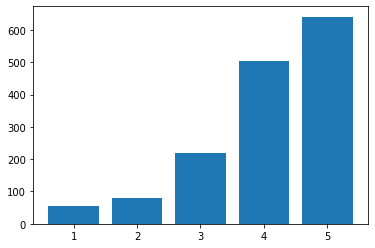

In [105]:
from collections import defaultdict

c = defaultdict(int)
for x in review_labels:
    c[x[1]] += 1

plt.bar(c.keys(), c.values())

In [41]:
# From the rating distribution, in order to reduce the skew of negative and positive, I set rating=5 as positive and otherwise is negative
review_features = [(x.split(' '), 'positive' if y > 4 else 'negative') for (x, y) in review_labels]

In [42]:
from nltk.sentiment import SentimentAnalyzer
import nltk.sentiment.util
from nltk.classify import NaiveBayesClassifier

random.shuffle(review_features)
training_docs = review_features[:1200]
test_docs = review_features[1200:]

print("Training: %d, Testing: %d" % (len(training_docs), len(test_docs)))

sentim_analyzer = SentimentAnalyzer()

Training: 1200, Testing: 300


In [43]:
all_words_neg = sentim_analyzer.all_words([nltk.sentiment.util.mark_negation(doc) for doc in training_docs])

In [76]:
#Using NaiveBayesClassifier
# when min_freq 2, I observed the highest F-measure by NaiveBayesClassifier
unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=2)
sentim_analyzer.add_feat_extractor(nltk.sentiment.util.extract_unigram_feats, unigrams=unigram_feats)

In [77]:
training_set = sentim_analyzer.apply_features(training_docs)
test_set = sentim_analyzer.apply_features(test_docs)

In [78]:
trainer = NaiveBayesClassifier.train
classifier = sentim_analyzer.train(trainer, training_set)
for key,value in sorted(sentim_analyzer.evaluate(test_set).items()):
     print('{0}: {1}'.format(key, value))

Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy: 0.6433333333333333
F-measure [negative]: 0.6934097421203439
F-measure [positive]: 0.5737051792828686
Precision [negative]: 0.6759776536312849
Precision [positive]: 0.5950413223140496
Recall [negative]: 0.711764705882353
Recall [positive]: 0.5538461538461539


In [ ]:
classifier2 = sentim_analyzer.train(trainer2(training_set,entropy_cutoff=0.4,support_cutoff=0.4), training_set)
for key,value in sorted(sentim_analyzer.evaluate(test_set).items()):
     print('{0}: {1}'.format(key, value))